# Install & import required packages

In [1]:
# !pip install tensorflow_io tensorflow_addons pydub

In [2]:
import os, sys, shutil
import pathlib
from glob import glob
from IPython import display
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras import models, Model
from tensorflow.image import ResizeMethod
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

c:\program files\python38\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


# Download dataset

In [3]:
# # train
# !gdown --id 19MpqPlGu23hfsF-kKM72VCU2AhC7fQ2a
# # !gdown --id 1UjmCtdOSP-HGPVlMKCLRzTkIQJ65CIcs # extra
#
# # test
# !gdown --id 1ix2wilO57zpEd-TcqNpUUQxRo0jzs4PH

# Extract dataset

In [4]:
# !unzip s1_release.zip
# # !unzip s1_hidden.zip
# !unzip s1_test_release.zip
#
# # for dir in os.listdir("s1_hidden"):
# #   for filename in os.listdir(f"s1_hidden/{dir}"):
# #     if not os.path.exists(f"s1_release/{dir}/{filename}"):
# #       shutil.copy(f"s1_hidden/{dir}/{filename}", f"s1_release/{dir}")

# Normalise average audio amplitude

In [5]:
# def match_target_amplitude(sound, target_dBFS):
#     change_in_dBFS = target_dBFS - sound.dBFS
#     return sound.apply_gain(change_in_dBFS)
#
# for path in glob("**/*.wav", recursive=True):
#   split_path = path.split("/")
#   if split_path[0].endswith("normalized"):
#     continue
#
#   normalized_sound_dir = split_path[0] + "_normalized"
#   if not os.path.exists(normalized_sound_dir):
#     os.mkdir(normalized_sound_dir)
#
#   # create subdirectories if file has label
#   if not split_path[1].endswith(".wav"):
#     normalized_sound_label_subdir = f"{normalized_sound_dir}/{split_path[1]}"
#     if not os.path.exists(normalized_sound_label_subdir):
#       os.mkdir(normalized_sound_label_subdir)
#
#   sound = AudioSegment.from_file(path, "wav")
#   normalized_sound = match_target_amplitude(sound, -20.0)
#
#   normalized_sound_path = split_path[0] + "_normalized/" + '/'.join(split_path[1:])
#   normalized_sound_path = normalized_sound_path[:-4] + "_normalized" + normalized_sound_path[-4:]
#   normalized_sound.export(normalized_sound_path, format="wav")
#
# sample_rate = 16000
#
# # s1_release/falcon/train_falcon_0276.wav is quieter than most other files
# # can't really hear the difference between displayed waveforms but I swear it's there
# waveform = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file('s1_release/falcon/train_falcon_0276.wav'), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)
# display.display(display.Audio(waveform, rate=sample_rate))
#
# waveform_normalized = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file('s1_release_normalized/falcon/train_falcon_0276_normalized.wav'), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)
# display.display(display.Audio(waveform_normalized, rate=sample_rate))
#
# print(waveform)
# print(waveform_normalized)

# Load data

In [6]:

# TODO BEFORE SUBMITTING CODE:
# remove val as test codes from data loading, see if need remove test files folder
# uncomment test_preprocess func and codes in data loading

# Data loading
seed = 69
AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(seed)
np.random.seed(seed)
sample_rate = 16000

# load normalized train set
# data_dir = pathlib.Path('s1_release')
data_dir = pathlib.Path('s1_release_normalized')
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
num_labels = len(labels)
print('Commands:', labels)

# Original
# filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
# filenames = tf.random.shuffle(filenames)
# num_samples = len(filenames)
# print('Number of total examples:', num_samples)
# print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
# print('Example file tensor:', filenames[0])
#
# train_files = filenames[:round(num_samples*0.8)]  # first 80%
# val_files = filenames[round(num_samples*0.8):]  # last 20%
#
# print('Training set size', len(train_files))
# print('Validation set size', len(val_files))

# load test as val
train_files = tf.io.gfile.glob(str(data_dir) + '/*/*')
train_files = tf.random.shuffle(train_files)
num_samples = len(train_files)
print('Number of train examples:', num_samples)
print('Number of train examples per label:', len(tf.io.gfile.listdir(str(data_dir/labels[0]))))

# val
val_file_ans = pd.read_csv('answers.csv', names=['file', 'label'])
# data_dir = pathlib.Path('s1_test_release_normalized')
# val_files = tf.io.gfile.glob(str(data_dir) + '/*')
# print('Val set size', len(val_files))
# for file in val_files:
#     row = val_file_ans[val_file_ans['file'] == os.path.basename(file).replace('_normalized', '')].index[0]
#     label = val_file_ans['label'][int(row)]
#     os.makedirs('test', exist_ok=True)
#     os.makedirs(os.path.join('test', label), exist_ok=True)
#     shutil.copy(file, os.path.join('test', label))
data_dir = pathlib.Path('test')
val_files = tf.io.gfile.glob(str(data_dir) + '/*/*')

# load given test set
data_dir = pathlib.Path('s1_test_release_normalized')
test_files = tf.io.gfile.glob(str(data_dir) + '/*')  # provided
print('Test set size', len(test_files))


Commands: ['bird' 'eight' 'falcon' 'five' 'four' 'nine' 'one' 'seven' 'six' 'snake'
 'three' 'two' 'zero']
Number of train examples: 3250
Number of train examples per label: 250
Test set size 649


tf.Tensor(
[-0.00054932 -0.00030518 -0.0007019  ...  0.18273926  0.0295105
 -0.17550659], shape=(16000,), dtype=float32)


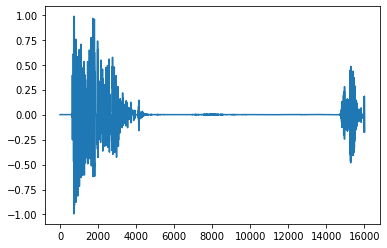

In [7]:
# Preprocessing
# Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
waveform = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file('s1_release/eight/train_eight_3153.wav'), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)
print(waveform)
display.display(display.Audio(waveform, rate=sample_rate))

plt.figure()
plt.plot(waveform.numpy())

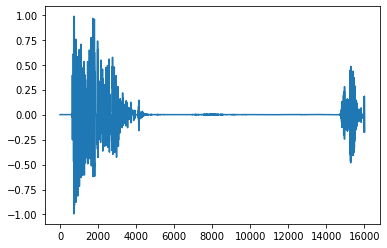

In [8]:
# zero pad to 16000  CHECKED
zero_padding = tf.zeros([sample_rate] - tf.shape(waveform), dtype=tf.float32)
waveform = tf.cast(waveform, tf.float32)
padded_audio_tensor = tf.concat([waveform, zero_padding], 0)
display.display(display.Audio(padded_audio_tensor, rate=sample_rate))
plt.figure()
plt.plot(padded_audio_tensor.numpy())

tf.Tensor(
[[[9.19405580e-01 9.19405580e-01 9.19405580e-01]
  [9.22616839e-01 9.22616839e-01 9.22616839e-01]
  [9.28478897e-01 9.28478897e-01 9.28478897e-01]
  ...
  [8.35476443e-02 8.35476443e-02 8.35476443e-02]
  [7.40904063e-02 7.40904063e-02 7.40904063e-02]
  [7.08163679e-02 7.08163679e-02 7.08163679e-02]]

 [[1.02819943e+00 1.02819943e+00 1.02819943e+00]
  [1.02960002e+00 1.02960002e+00 1.02960002e+00]
  [1.03702199e+00 1.03702199e+00 1.03702199e+00]
  ...
  [9.56348926e-02 9.56348926e-02 9.56348926e-02]
  [8.55350122e-02 8.55350122e-02 8.55350122e-02]
  [8.20331872e-02 8.20331872e-02 8.20331872e-02]]

 [[1.12024951e+00 1.12024951e+00 1.12024951e+00]
  [1.12423718e+00 1.12423718e+00 1.12423718e+00]
  [1.12979591e+00 1.12979591e+00 1.12979591e+00]
  ...
  [1.06615774e-01 1.06615774e-01 1.06615774e-01]
  [9.60391164e-02 9.60391164e-02 9.60391164e-02]
  [9.23504829e-02 9.23504829e-02 9.23504829e-02]]

 ...

 [[5.99447172e-04 5.99447172e-04 5.99447172e-04]
  [6.50593138e-04 6.50593138

<tf.Tensor: shape=(), dtype=bool, numpy=True>

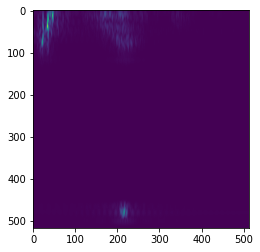

In [9]:
# spectrogram CHECKED
spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
spectrogram = tf.abs(spectrogram)
plt.figure()
plt.imshow(spectrogram.numpy())
spectrogram = tf.expand_dims(spectrogram, -1)
spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
print(spectrogram)
print(f'spectrogram shape: {spectrogram.shape}')

tf.reduce_all(tf.equal(spectrogram, spectrogram))

In [10]:
# NOT CHECKED
# # Trim noise (TODO: try with different gate, default 0.1)
# position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
# print(position)
# start = position[0]
# stop = position[1]
# print(start, stop)
# trimmed_audio_tensor = audio_tensor[start:stop]
# display.display(display.Audio(trimmed_audio_tensor, rate=sample_rate))
# plt.figure()
# plt.plot(trimmed_audio_tensor.numpy())
#
# # Fade in fade out (TODO: to try)
# faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")
# display.display(display.Audio(faded_audio_tensor, rate=sample_rate))
# plt.figure()
# plt.plot(faded_audio_tensor.numpy())
#
# # zero pad to 16000
# zero_padding = tf.zeros([sample_rate] - tf.shape(faded_audio_tensor), dtype=tf.float32)
# faded_audio_tensor = tf.cast(faded_audio_tensor, tf.float32)
# padded_audio_tensor = tf.concat([faded_audio_tensor, zero_padding], 0)
# display.display(display.Audio(padded_audio_tensor, rate=sample_rate))
# plt.figure()
# plt.plot(padded_audio_tensor.numpy())
#
# # Convert to spectrogram and merge into 3 channels
# # first line is from paper, 2nd is halved
# # stft_params = [{'nfft': 1024, 'window': 800, 'stride': 320}, {'nfft': 2048, 'window': 1600, 'stride': 800}, {'nfft': 4096, 'window': 3200, 'stride': 1600}]  # stride = hop size
# stft_params = [{'nfft': 512, 'window': 400, 'stride': 160}, {'nfft': 1024, 'window': 800, 'stride': 400}, {'nfft': 2048, 'window': 1600, 'stride': 800}]  # stride = hop size
# spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride'])
# spectrogram_1 = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride'])
# spectrogram_2 = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[1]['nfft'], window=stft_params[1]['window'], stride=stft_params[1]['stride'])
# spectrogram_3 = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[2]['nfft'], window=stft_params[2]['window'], stride=stft_params[2]['stride'])
# print(f'spectrogram shape: {spectrogram.shape}')
# plt.figure()
# plt.imshow(spectrogram.numpy())
#
# # Convert to mel-spectrogram
# mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)
# plt.figure()
# plt.imshow(mel_spectrogram.numpy())
#
# # Convert to db scale mel-spectrogram (TODO: to try)
# dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
# plt.figure()
# plt.imshow(dbscale_mel_spectrogram.numpy())
#
# # Convert to log-mel spectrogram
# log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
# print(f'log spectrogram shape: {log_mel_spectrogram.shape}')
# plt.figure()
# plt.imshow(log_mel_spectrogram.numpy())
#
# # Freq masking
# freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)
# plt.figure()
# plt.imshow(freq_mask.numpy())
#
# # Time masking
# time_mask = tfio.audio.time_mask(freq_mask, param=6)
# plt.figure()
# plt.imshow(time_mask.numpy())
#
# # MFCC
# mfccs = tf.signal.mfccs_from_log_mel_spectrograms(time_mask)
# print(f'MFCC Shape: {mfccs.shape}')
# print(mfccs)
#
# print(spectrogram_1)
# spectrogram_1 = tf.expand_dims(spectrogram_1, -1)
# spectrogram_1 = tf.image.resize_with_pad(spectrogram_1, 224, 224, method=ResizeMethod.LANCZOS5)
# spectrogram_2 = tf.expand_dims(spectrogram_2, -1)
# spectrogram_2 = tf.image.resize_with_pad(spectrogram_2, 224, 224, method=ResizeMethod.LANCZOS5)
# spectrogram_3 = tf.expand_dims(spectrogram_3, -1)
# spectrogram_3 = tf.image.resize_with_pad(spectrogram_3, 224, 224, method=ResizeMethod.LANCZOS5)
# log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram_1, spectrogram_2, spectrogram_3], axis=-1))
# print(log_mel_spectrogram)

In [11]:
stft_params = [{'nfft': 512, 'window': 501, 'stride': 21}, {'nfft': 1024, 'window': 1001, 'stride': 31}, {'nfft': 2048, 'window': 1600, 'stride': 61}]  # stride = hop size

def train_preprocess(file_path):
    # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
    audio_tensor = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file(file_path), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)

    # Trim noise (TODO: try with different gate, default 0.1)
    # position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.1)  # epsilon = noise gate (how loud between 0 to 1)
    # audio_tensor = audio_tensor[position[0]:position[1]]
    # faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")

    # zero pad to 16000  CHECKED
    zero_padding = tf.zeros([sample_rate] - tf.shape(audio_tensor), dtype=tf.float32)
    audio_tensor = tf.cast(audio_tensor, tf.float32)
    padded_audio_tensor = tf.concat([audio_tensor, zero_padding], 0)

    # spectrogram CHECKED
    spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride']))
    spectrogram1 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride']))
    spectrogram2 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[1]['nfft'], window=stft_params[1]['window'], stride=stft_params[1]['stride']))
    spectrogram3 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[2]['nfft'], window=stft_params[2]['window'], stride=stft_params[2]['stride']))

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram1 = tfio.audio.melscale(spectrogram1, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram2 = tfio.audio.melscale(spectrogram2, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram3 = tfio.audio.melscale(spectrogram3, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    #
    # Convert to db scale mel-spectrogram (TODO: to try)
    # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    #
    # Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    log_mel_spectrogram1 = tf.math.log(mel_spectrogram1 + 1e-6)
    log_mel_spectrogram2 = tf.math.log(mel_spectrogram2 + 1e-6)
    log_mel_spectrogram3 = tf.math.log(mel_spectrogram3 + 1e-6)
    #
    # Freq masking
    freq_mask = tfio.audio.freq_mask(log_mel_spectrogram, param=10)
    freq_mask1 = tfio.audio.freq_mask(log_mel_spectrogram1, param=10)
    freq_mask2 = tfio.audio.freq_mask(log_mel_spectrogram2, param=10)
    freq_mask3 = tfio.audio.freq_mask(log_mel_spectrogram3, param=10)

    # Time masking
    time_mask = tfio.audio.time_mask(freq_mask, param=6)
    time_mask1 = tfio.audio.time_mask(freq_mask1, param=6)
    time_mask2 = tfio.audio.time_mask(freq_mask2, param=6)
    time_mask3 = tfio.audio.time_mask(freq_mask3, param=6)
    #
    # # MFCC
    # mfccs = tf.signal.mfccs_from_log_mel_spectrograms(time_mask)

    # label id extraction
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_id = tf.argmax(label == labels)

    # time_mask = tf.expand_dims(time_mask, -1)
    # time_mask = tf.squeeze(tf.stack([time_mask, time_mask, time_mask], axis=-1))  # 3 channel

    time_mask1 = tf.expand_dims(time_mask1, -1)
    time_mask1 = tf.image.resize(time_mask1, (224, 224), method=ResizeMethod.LANCZOS5)
    time_mask2 = tf.expand_dims(time_mask2, -1)
    time_mask2 = tf.image.resize(time_mask2, (224, 224), method=ResizeMethod.LANCZOS5)
    time_mask3 = tf.expand_dims(time_mask3, -1)
    time_mask3 = tf.image.resize(time_mask3, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram = tf.squeeze(tf.stack([time_mask1, time_mask2, time_mask3], axis=-1))
    log_mel_spectrogram.set_shape([224, 224, 3])
    return log_mel_spectrogram, label_id  # Switch output here, log, dbscale, freq mask, time mask, mfccs

def val_preprocess(file_path):
    # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
    audio_tensor = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file(file_path), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)

    # Trim noise (TODO: try with different gate, default 0.1)
    # position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.1)  # epsilon = noise gate (how loud between 0 to 1)
    # audio_tensor = audio_tensor[position[0]:position[1]]
    # faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")

    # zero pad to 16000  CHECKED
    zero_padding = tf.zeros([sample_rate] - tf.shape(audio_tensor), dtype=tf.float32)
    audio_tensor = tf.cast(audio_tensor, tf.float32)
    padded_audio_tensor = tf.concat([audio_tensor, zero_padding], 0)

     # spectrogram CHECKED
    spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride']))
    spectrogram1 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride']))
    spectrogram2 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[1]['nfft'], window=stft_params[1]['window'], stride=stft_params[1]['stride']))
    spectrogram3 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[2]['nfft'], window=stft_params[2]['window'], stride=stft_params[2]['stride']))

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram1 = tfio.audio.melscale(spectrogram1, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram2 = tfio.audio.melscale(spectrogram2, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram3 = tfio.audio.melscale(spectrogram3, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    #
    # Convert to db scale mel-spectrogram (TODO: to try)
    # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    #
    # Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    log_mel_spectrogram1 = tf.math.log(mel_spectrogram1 + 1e-6)
    log_mel_spectrogram2 = tf.math.log(mel_spectrogram2 + 1e-6)
    log_mel_spectrogram3 = tf.math.log(mel_spectrogram3 + 1e-6)

    # label id extraction
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_id = tf.argmax(label == labels)

    # log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
    # log_mel_spectrogram = tf.squeeze(tf.stack([log_mel_spectrogram, log_mel_spectrogram, log_mel_spectrogram], axis=-1))  # 3 channel
    # log_mel_spectrogram.set_shape([517, 128, 3])
    log_mel_spectrogram1 = tf.expand_dims(log_mel_spectrogram1, -1)
    log_mel_spectrogram1 = tf.image.resize(log_mel_spectrogram1, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram2 = tf.expand_dims(log_mel_spectrogram2, -1)
    log_mel_spectrogram2 = tf.image.resize(log_mel_spectrogram2, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram3 = tf.expand_dims(log_mel_spectrogram3, -1)
    log_mel_spectrogram3 = tf.image.resize(log_mel_spectrogram3, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram = tf.squeeze(tf.stack([log_mel_spectrogram1, log_mel_spectrogram2, log_mel_spectrogram3], axis=-1))
    log_mel_spectrogram.set_shape([224, 224, 3])
    return log_mel_spectrogram, label_id  # switch output here to db or log

def test_preprocess(file_path):
    # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
    audio_tensor = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file(file_path), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)

    # Trim noise (TODO: try with different gate, default 0.1)
    # position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.1)  # epsilon = noise gate (how loud between 0 to 1)
    # audio_tensor = audio_tensor[position[0]:position[1]]
    # faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")

    # zero pad to 16000  CHECKED
    zero_padding = tf.zeros([sample_rate] - tf.shape(audio_tensor), dtype=tf.float32)
    audio_tensor = tf.cast(audio_tensor, tf.float32)
    padded_audio_tensor = tf.concat([audio_tensor, zero_padding], 0)

     # spectrogram CHECKED
    spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride']))
    spectrogram1 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride']))
    spectrogram2 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[1]['nfft'], window=stft_params[1]['window'], stride=stft_params[1]['stride']))
    spectrogram3 = tf.abs(tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[2]['nfft'], window=stft_params[2]['window'], stride=stft_params[2]['stride']))

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram1 = tfio.audio.melscale(spectrogram1, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram2 = tfio.audio.melscale(spectrogram2, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    mel_spectrogram3 = tfio.audio.melscale(spectrogram3, rate=sample_rate, mels=224, fmin=20, fmax=8000)
    #
    # Convert to db scale mel-spectrogram (TODO: to try)
    # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    #
    # Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    log_mel_spectrogram1 = tf.math.log(mel_spectrogram1 + 1e-6)
    log_mel_spectrogram2 = tf.math.log(mel_spectrogram2 + 1e-6)
    log_mel_spectrogram3 = tf.math.log(mel_spectrogram3 + 1e-6)

    # log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
    # log_mel_spectrogram = tf.squeeze(tf.stack([log_mel_spectrogram, log_mel_spectrogram, log_mel_spectrogram], axis=-1))  # 3 channel
    # log_mel_spectrogram.set_shape([517, 128, 3])
    log_mel_spectrogram1 = tf.expand_dims(log_mel_spectrogram1, -1)
    log_mel_spectrogram1 = tf.image.resize(log_mel_spectrogram1, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram2 = tf.expand_dims(log_mel_spectrogram2, -1)
    log_mel_spectrogram2 = tf.image.resize(log_mel_spectrogram2, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram3 = tf.expand_dims(log_mel_spectrogram3, -1)
    log_mel_spectrogram3 = tf.image.resize(log_mel_spectrogram3, (224, 224), method=ResizeMethod.LANCZOS5)
    log_mel_spectrogram = tf.squeeze(tf.stack([log_mel_spectrogram1, log_mel_spectrogram2, log_mel_spectrogram3], axis=-1))
    log_mel_spectrogram.set_shape([224, 224, 3])
    return log_mel_spectrogram  # switch output here to db or log


train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(train_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(val_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(test_preprocess, num_parallel_calls=AUTOTUNE)

for spectrogram, label in train_ds.take(1):
    input_shape = spectrogram.shape
# audio_tensor, label = get_waveform_and_label('s1_release/s1_release/bird/train_bird_8400.wav')
# tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
# plt.figure()
# plt.plot(tensor.numpy())

In [12]:
# Training
batch_size = 16
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

print('Input shape:', input_shape)
norm_layer = Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

# DenseNet201 pretrained
xInput = Input(input_shape, dtype=tf.uint8)
# x = Resizing(224, 224)(xInput)
x = norm_layer(xInput)
x = tf.cast(x, tf.float32)
densenet201 = keras.applications.DenseNet201(include_top=False, weights='imagenet')
densenet201.trainable = True
x = densenet201(x)
x = Flatten()(x)
# x = Dropout(0.2)(x)
# x = Dense(512)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(256)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
xOutput = Dense(num_labels)(x)  # no activation as loss using logit=True
model = tf.keras.models.Model(xInput, xOutput)

Input shape: (224, 224, 3)


In [13]:
opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-6)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='SC1v2.png') # SC1_ensemble.png
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
dropout (Dropout)            (None, 94080)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               120423

In [14]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)
model.save('sc1v2')

Epoch 1/100
204/204 [==============================] - 67s 237ms/step - loss: 1.0318 - accuracy: 0.6794 - val_loss: 2.2941 - val_accuracy: 0.4700

In [15]:
# Generate prediction csv
# print('Loading model...')
# model = models.load_model('sc1v2')
# print('Model loaded. Predicting...')
i = 0
predicted_labels, filenames = [], []
for spectrogram in test_ds.batch(1):
    filenames.append(os.path.basename(test_files[i].replace('_normalized', '')))
    prediction = model(spectrogram)
    prediction_value = tf.nn.softmax(prediction[0]).numpy()
    predicted_label = labels[np.argmax(prediction_value)]
    predicted_labels.append(predicted_label)
    i+=1

df = pd.DataFrame(list(zip(filenames, predicted_labels)))
df.to_csv('challenge_2_team_Tensor is not flowing.csv', index=False, header=False)  # tested submission file format passed

In [16]:
# val_ds = val_ds.batch(16).cache().prefetch(AUTOTUNE)
# model.evaluate(val_ds)
# print(df)
'''
DenseNet201 with norm no preprocess, dropout 0.2: 91.38
stft_params = [{'nfft': 512, 'window': 501, 'stride': 21}, {'nfft': 1024, 'window': 1001, 'stride': 31}, {'nfft': 2048, 'window': 1600, 'stride': 61}]  # stride = hop size
before add data: 9291

time and freq mask dont work well
'''

ValueError: in user code:

    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1323 test_function  *
        return step_function(self, iterator)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\program files\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\program files\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\program files\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1307 run_step  **
        outputs = model.test_step(data)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1266 test_step
        y_pred = self(x, training=False)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 224, 224, 3), found shape=(None, None, 224, 224, 3)
